In [119]:
import numpy as np
import matplotlib.pyplot as plt, mpld3
import pandas as pd
import scipy as sp
import scipy.stats
import plotly.plotly as py
from plotly.graph_objs import *

%matplotlib inline

In [4]:
import block_handler
import plot_chunk

#  Minepath Eval

In [5]:
world = block_handler.load_world('/Users/ryanlambert/Desktop/MinecraftLandGenerator/world')

In [6]:
#print world.get_nbt(-9,-46)['Level']['Sections'][0]['Blocks']

In [7]:
world.get_boundingbox()

BoundingBox(-27,35,None,None,-30,32)

### Path Type: Hallway
Combinations of various heights and spacings

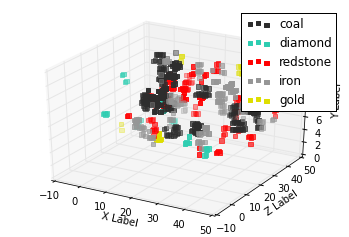

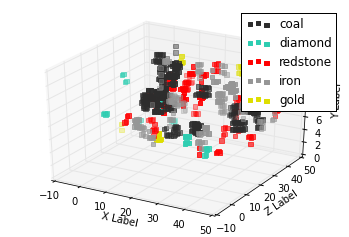

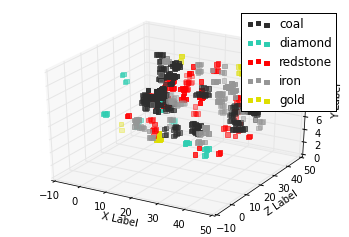

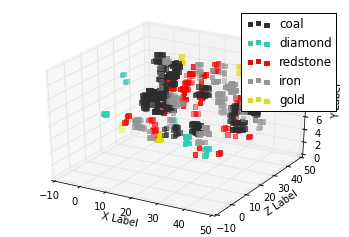

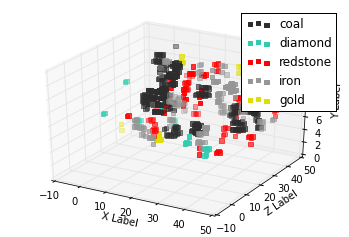

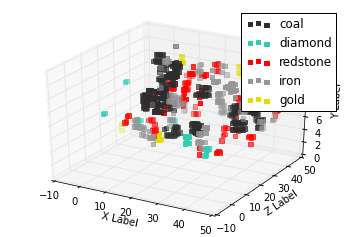

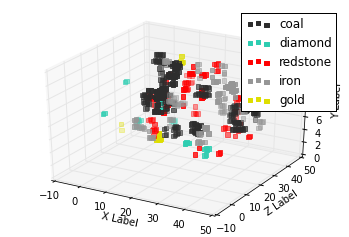

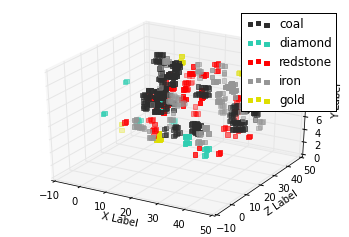

In [8]:
def mine_hallway_variations(hallway_spacing, 
                            hallway_height, 
                            max_y_height, 
                            y_layer_spacing):
    ### mine path must fit in 48 x 48 space
    hallway = []
    for y_pattern in xrange(6, max_y_height, y_layer_spacing): 
        for x in xrange(1, 46, hallway_spacing):
            for z in xrange(1, 47):
                for y in range(y_pattern, y_pattern + hallway_height):
                    hallway.append((x,z,y))

#     fig = plt.figure()
#     ax = fig.add_subplot(111, projection='3d')
#     try:
#         xs = [i[0] for i in hallway]
#         zs = [j[1] for j in hallway]
#         ys = [k[2] for k in hallway]
#         ax.scatter(xs, zs, ys, color='green', marker='|')
#         ax.set_zlim3d([0, 17])
#         ax.set_title("Hallway_spacing: %r \n Hallway Height: %s \n Max Y: %s \n Y Spacing: %s"% (hallway_spacing, hallway_height, max_y_height, y_layer_spacing)) 
#         ax.set_xlabel('X')
#         ax.set_ylabel('Z')
#         ax.set_zlabel('Y')
#     except KeyError:
#         print "keyerror"
#         pass

    hallway_ore_filter = {
        'iron':0,
        'diamond':0,
        'redstone':0,
        'coal':0,
        'gold':0,
    }

    blocks, mining_pathway = block_handler.simulation(
        x1=0,
        x2=3,
        z1=0,
        z2=3,
        y1=0,
        y2=1,
        relative_path=hallway,
        ore_count=hallway_ore_filter,
        world=world)

    multi_index_labels = [
        'Hallway Spacing',
        'Hallway Height',
        'Y Spacing',
#         'type'
    ]
    multi_index_columns = [
        hallway_spacing,
        hallway_height,
        y_layer_spacing,
#         ['pathway or ore']
    ]
    
    ore_columns = pd.MultiIndex.from_arrays(
        multi_index_columns,
        names=multi_index_labels
    )
    path_columns = pd.MultiIndex.from_arrays(
        multi_index_columns,
        names=multi_index_labels,
    )

    temp_ores = pd.DataFrame(
        blocks.values(),
        [
            [i[0] for i in blocks.keys()],
            [i[1] for i in blocks.keys()],
            [i[2] for i in blocks.keys()],
        ],
        columns=ore_columns)


    temp_pathway = pd.DataFrame(
        ['pathway' for i in mining_pathway],
        index=[
            [i[0] for i in mining_pathway],
            [i[1] for i in mining_pathway],
            [i[2] for i in mining_pathway],
        ],
        columns=path_columns
    )
#     temp = pd.concat([temp_ores, temp_pathway], join='outer', axis=1)
#     return temp
    return temp_ores, temp_pathway

    

# df = pd.DataFrame()
df_sample_size = pd.DataFrame()
df_ores = pd.DataFrame()
df_paths = pd.DataFrame()
for y_layer_spacing in [3, 4]:
    for hallway_spacing in [2, 3]:
        for hallway_height in [2, 3]:
            temp_ores, temp_pathway = mine_hallway_variations(
                hallway_spacing=hallway_spacing, 
                hallway_height=hallway_height, 
                max_y_height=16, 
                y_layer_spacing=y_layer_spacing
                )
            sample_size_coordinates = pd.Series(
                {
                'x_sample_size':hallway_spacing * 4,
                'z_sample_size':hallway_spacing * 4,
                'y_sampe_size':y_layer_spacing
                },
                name='%r, %r, %r' % (
                    hallway_spacing,
                    hallway_height,
                    y_layer_spacing
                )
            )

        
#             df = pd.concat([df, temp], join='outer', axis=1)
            df_ores = pd.concat([df_ores, temp_ores], join='outer', axis=1)            
            df_paths = pd.concat([df_paths, temp_pathway], join='outer', axis=1)
            df_sample_size = df_sample_size.append(sample_size_coordinates)
df_ores = df_ores.sortlevel(2).sortlevel(1).sortlevel(0)
df_paths = df_paths.sortlevel(2).sortlevel(1).sortlevel(0)
#df_sample_size = df_sample_size.sortlevel(2).sortlevel(1).sortlevel(0)
# df = df.sortlevel(2).sortlevel(1).sortlevel(0)
# df_ores = df.iloc[:, 0::2]
# df_paths = df.iloc[:,1::2]


In [9]:
def cases_sample_sum_counts(df_ores):
    newdf_ores = pd.DataFrame()
    for column in df_ores:
        x_sample_size = int(df_sample_size['x_sample_size'][str([column[0], column[1], column[2]]).strip(']').strip('[')])
        z_sample_size = int(df_sample_size['z_sample_size'][str([column[0], column[1], column[2]]).strip(']').strip('[')])
        for x_subset in range(0, 47, x_sample_size):
            for z_subset in range(0, 47, z_sample_size):
                temp_append = df_ores.loc[
                (
                    slice(x_subset, x_subset + x_sample_size - 1),
                    slice(z_subset, z_subset + z_sample_size - 1),                    
    #                 slice(0, 15), 
        #             slice(0, 15),
                ),
                :
            ][column[0]][column[1]][column[2]].value_counts()
                temp_append.name = '%s, %s, %s' % (column[0], column[1], column[2])
        #     print temp_append
        #     print newdf
                newdf_ores = newdf_ores.append(temp_append)
    newdf_ores = newdf_ores.sort()
    return newdf_ores

newdf_ores = cases_sample_sum_counts(df_ores)
newdf_path_count = cases_sample_sum_counts(df_paths)
path_size_mean = newdf_path_count.groupby(newdf_path_count.index).mean()
newdf_ores_count = newdf_ores.groupby(newdf_ores.index).count()
newdf_ores_sample_count = pd.DataFrame(newdf_ores.index.value_counts(), 
             columns=['sample_size']
            ).sort()


### Mean, STDEV, Sample Count

##### first need efficiencies

In [23]:
individual_sample_efficiencies = newdf_ores.divide(newdf_path_count['pathway'], axis='index')
efficiency_means = individual_sample_efficiencies.fillna(0).groupby(individual_sample_efficiencies.index).mean()
efficiency_stdevs = individual_sample_efficiencies.fillna(0).groupby(individual_sample_efficiencies.index).std()

In [72]:
newdf_ores_sample_count

,sample_size
"2, 2, 3",36
"2, 2, 4",36
"2, 3, 3",36
"2, 3, 4",36
"3, 2, 3",16
"3, 2, 4",16
"3, 3, 3",16
"3, 3, 4",16


In [31]:
efficiency_means

,diamond,gold,coal,iron,redstone
"2, 2, 3",0.004697,0.002263,0.034299,0.019046,0.017247
"2, 2, 4",0.005353,0.002646,0.044402,0.023327,0.019214
"2, 3, 3",0.003379,0.001653,0.025532,0.014705,0.013197
"2, 3, 4",0.003899,0.001984,0.031346,0.017784,0.015106
"3, 2, 3",0.007546,0.003314,0.047526,0.028232,0.023442
"3, 2, 4",0.007891,0.002959,0.061474,0.034242,0.024338
"3, 3, 3",0.005623,0.002427,0.036534,0.022254,0.018282
"3, 3, 4",0.006050,0.002604,0.044740,0.026927,0.020255


In [39]:
efficiency_stdevs

,diamond,gold,coal,iron,redstone
"2, 2, 3",0.009113,0.007876,0.049463,0.015562,0.017182
"2, 2, 4",0.010741,0.007547,0.062057,0.019438,0.017690
"2, 3, 3",0.006792,0.005424,0.036774,0.012378,0.012761
"2, 3, 4",0.008251,0.006088,0.043628,0.015625,0.013941
"3, 2, 3",0.010460,0.007691,0.044291,0.022607,0.016768
"3, 2, 4",0.010679,0.005871,0.056911,0.027396,0.018266
"3, 3, 3",0.007290,0.005256,0.032939,0.018139,0.013016
"3, 3, 4",0.007819,0.005084,0.040040,0.021555,0.015130


In [140]:
efficiency_stderrors = efficiency_stdevs.divide(np.sqrt(newdf_ores_sample_count['sample_size']),
                                               axis='index')
efficiency_stderrors

,diamond,gold,coal,iron,redstone
"2, 2, 3",0.001519,0.001313,0.008244,0.002594,0.002864
"2, 2, 4",0.001790,0.001258,0.010343,0.003240,0.002948
"2, 3, 3",0.001132,0.000904,0.006129,0.002063,0.002127
"2, 3, 4",0.001375,0.001015,0.007271,0.002604,0.002324
"3, 2, 3",0.002615,0.001923,0.011073,0.005652,0.004192
"3, 2, 4",0.002670,0.001468,0.014228,0.006849,0.004566
"3, 3, 3",0.001822,0.001314,0.008235,0.004535,0.003254
"3, 3, 4",0.001955,0.001271,0.010010,0.005389,0.003783


$$Confidence\, Interval = SE * t_{.95}$$

Here I use 'scipy.stats.t.ppf' to calculate this.  
    

In [144]:
confidence_margins_95 = pd.DataFrame()
confidence = .95
for i in efficiency_stderrors.index:
    temp = efficiency_stderrors.loc[i] * sp.stats.t.ppf(
        (1 + confidence)/2.,
        newdf_ores_sample_count['sample_size'].loc[i]
    )
    confidence_margins_95 = confidence_margins_95.append(temp)
confidence_margins_95

,coal,diamond,gold,iron,redstone
"2, 2, 3",0.016719,0.003080,0.002662,0.005260,0.005808
"2, 2, 4",0.020976,0.003631,0.002551,0.006570,0.005979
"2, 3, 3",0.012430,0.002296,0.001834,0.004184,0.004313
"2, 3, 4",0.014747,0.002789,0.002058,0.005281,0.004712
"3, 2, 3",0.023473,0.005544,0.004076,0.011981,0.008887
"3, 2, 4",0.030162,0.005660,0.003112,0.014519,0.009680
"3, 3, 3",0.017457,0.003864,0.002786,0.009613,0.006898
"3, 3, 4",0.021220,0.004144,0.002694,0.011424,0.008019


In [145]:
efficiency_means + confidence_margins_95

,coal,diamond,gold,iron,redstone
"2, 2, 3",0.051018,0.007777,0.004925,0.024306,0.023055
"2, 2, 4",0.065378,0.008984,0.005196,0.029898,0.025194
"2, 3, 3",0.037962,0.005675,0.003487,0.018889,0.017510
"2, 3, 4",0.046093,0.006688,0.004042,0.023065,0.019818
"3, 2, 3",0.070999,0.013090,0.007391,0.040213,0.032329
"3, 2, 4",0.091636,0.013551,0.006071,0.048761,0.034019
"3, 3, 3",0.053991,0.009486,0.005212,0.031867,0.025180
"3, 3, 4",0.065960,0.010194,0.005298,0.038351,0.028273


### Path Type: Branch Leaf: leaf_spacing = 4, branch_spacing = 12

In [ ]:
branch_leaf = []
leaf_spacing = 4
branch_spacing = 12
for y_pattern in xrange(0, 4, 3): 
    for x in xrange(6, 42, branch_spacing):
        for z in xrange(2, 48):
            for y in range(6 + y_pattern,8 + y_pattern):
                branch_leaf.append((x,z,y))
    ### leaves
        for z in xrange(3, 48, leaf_spacing): 
            for x_2 in xrange(x, x + 6): 
                for y in range(7 + y_pattern,8 + y_pattern):
                    branch_leaf.append((x_2,z,y))
            for x_3 in xrange(x - 5, x): 
                for y in range(7 + y_pattern,8 + y_pattern):
                    branch_leaf.append((x_3,z,y))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

try:
    xs = [i[0] for i in branch_leaf]
    zs = [j[1] for j in branch_leaf]
    ys = [k[2] for k in branch_leaf]
    ax.scatter(xs, zs, ys, color='green', marker='|')
    ax.set_zlim3d([0, 17])
    ax.set_xlabel('X Label')
    ax.set_ylabel('Z Label')
    ax.set_zlabel('Y Label')
except KeyError:
    pass

branch_leaf_ore_filter = {
    'iron':0,
    'diamond':0,
    'redstone':0,
#    'coal':0,
    'gold':0,
}
blocks, branch_leaf = block_handler.simulation(
    x1=-15,
    x2=15,
    z1=-15,
    z2=15,
    y1=0,
    y2=1,
    relative_path=branch_leaf,
    ore_count=branch_leaf_ore_filter,
    world=world)
ore_counts = pd.DataFrame([branch_leaf_ore_filter], index=['branch_leaf lf_space=4 br_space=12'])
branch_leaf_efficiency = ore_counts / len(branch_leaf) * 100
branch_leaf_efficiency
print len(blocks)
index_x = [i[0] for i in blocks.keys()]
index_z = [i[1] for i in blocks.keys()]
index_y = [i[2] for i in blocks.keys()]
pandasblocks['branch_leaf lf_space=4 br_space=12'] = pd.DataFrame(blocks.values(), [index_x, index_z, index_y])

### Comparison of Paths' Performance

In [ ]:
all_efficiencies = pd.concat([branch_leaf_lf3_br12_efficiency,
                    branch_leaf_efficiency, 
                    branch_leaf_lf5_br12_efficiency,
                    branch_leaf_lf6_br12_efficiency,
                    branch_leaf_lf7_br12_efficiency,
                    one_by_two_efficiency, 
                    one_by_two_4space_efficiency,
                             ])
all_efficiencies

In [ ]:
branch_leaf_efficiencies = pd.concat([branch_leaf_lf3_br12_efficiency,
                    branch_leaf_efficiency, 
                    branch_leaf_lf5_br12_efficiency,
                    branch_leaf_lf6_br12_efficiency,
                    branch_leaf_lf7_br12_efficiency,
                    ])
branch_leaf_efficiencies

In [ ]:
branch_leaf_efficiencies.sort().T.plot(kind='bar', title="Branch_Leaf_Mining_Efficiencies", figsize=(10,7))

In [ ]:
one_by_two_efficiencies = pd.concat([one_by_two_efficiency, 
                    one_by_two_4space_efficiency,
                    one_by_two_6space_efficiency,
                    one_by_two_8space_efficiency,
                    one_by_two_10space_efficiency,])
one_by_two_efficiencies

In [ ]:
one_by_two_efficiencies.sort().T.plot(kind='bar', title="1 x 2 spacing optimization", figsize=(10,7))

### Compare the Two Top Performers for Diamonds

In [ ]:
top_diamond_performers = pd.concat([branch_leaf_efficiency, one_by_two_efficiency])
top_diamond_performers.diamond.plot(kind='bar', title='Diamonds', grid=True)
top_diamond_performers.T.plot(kind='bar')

##### Send to plot.ly

In [ ]:
top_diamond_performers.T.index.tolist()

In [ ]:
branch_leaf_data = top_diamond_performers.T['branch_leaf lf_space=4 br_space=12'].tolist()
one_by_two = top_diamond_performers.T['one_by_two_3space'].tolist()

In [ ]:
trace1 = Bar(
    x=top_diamond_performers.T.index.tolist(),
    y=branch_leaf_data,
    name='branch_leaf'
)

trace2 = Bar(
    x=top_diamond_performers.T.index.tolist(),
    y=one_by_two,
    name='one_by_two'
)

data = Data([trace1, trace2])
layout = Layout(
    barmode='group'
)
fig = Figure(data=data, layout=layout)
plot_url = py.plot(fig, filename='test1234')